## LKH Heuristic

In [123]:
import json

import os
from glob import glob
fs = glob("LKH_solutions/*")
tasks = []
lkh_times = []
lkh_objs = []
lkh_opt_gaps = []
for f in fs:
    obj = json.load(open(f))
    time = obj['warmstart_latency']
    objective = obj['current_obj']
    task = os.path.basename(f).split("_solution")[0]
    tasks.append(task)
    lkh_times.append(time)
    lkh_objs.append(int(objective))
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    lkh_opt_gaps.append((objective - opt) / opt * 100)

In [124]:
import pandas as pd
pd.set_option('display.precision', 4)
dataframe = pd.DataFrame([lkh_times, lkh_objs, lkh_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps (%)'])
dataframe


,d1291,rl5934,brd14051,dsj1000,d15112,d2103,pla7397,fl1577
time,1.6021,37.7036,232.8105,1.0774e+00,3.1645e+02,4.4003,5.8726e+01,3.5105
objective,51112.0000,564699.0000,474929.0000,1.8692e+07,1.5923e+06,80883.0000,2.3454e+07,22305.0000
optimality_gaps (%),0.6122,1.5563,1.1811,1.6858e-01,1.2195e+00,0.5382,8.3163e-01,0.2517


## LKH-runs

In [125]:
dataframe_lkhruns = pd.read_csv("baseline_lkh3_runs_records.csv")
dataframe_lkhruns = dataframe_lkhruns.set_index("Unnamed: 0")
dataframe_lkhruns

,d1291,dsj1000,d15112,d2103,fl1577,rl5934,pla7397,brd14051
Unnamed: 0,,,,,,,,
time,248.8,10.94,2974.50,96.41,6.13,554.94,783.51,1980.12
optimality_gaps (%),0.0,0.00,0.84,0.00,0.00,0.19,0.19,0.75


## ViTSP

Reasoning: GPT o4
- input: $1.1
- output: $4.4

Fast thinking: GPT 4.1
- input: $2
- output: $8


In [69]:
from helper.parse_instances import FileParser
import numpy as np

# calculate route
def cal_route_dist(route, task):
    file_parser = FileParser()
    instance_info = file_parser.parse_instance_from_file(f"instances/tsplib/{task}.tsp")
    node_coords = {i+1: np.array([x[0], x[1]]) for i, x in enumerate(instance_info["COORDINATES"])}

    total_dist = 0

    if instance_info['EDGE_WEIGHT_TYPE'] == "CEIL_2D":
        dist_func = lambda x1, x2: int(np.ceil(np.linalg.norm(x1 - x2)))
    elif instance_info['EDGE_WEIGHT_TYPE'] == "EUC_2D":
        dist_func = lambda x1, x2: int(np.sqrt(np.sum((x1 - x2) ** 2)) + 0.5)

    # if instance_info['EDGE_WEIGHT_TYPE'] == "CEIL_2D":
    #     dist_func = lambda x1, x2: np.ceil(np.linalg.norm(x1 - x2))
    # elif instance_info['EDGE_WEIGHT_TYPE'] == 'EUC_2D':
    #     dist_func = lambda x1, x2: np.floor(np.linalg.norm(x1 - x2) + 0.5)

    for i in range(len(route) - 1):
        node1 = node_coords[route[i]]
        if i == len(route) - 2:
            node2 = node_coords[route[0]]
        else:
            node2 = node_coords[route]
        total_dist += dist_func(node1, node2)

    return total_dist


In [70]:
task = 'dsj1000'
exp_name = "{}_max_nodes_1000_time_budget_100_initial_LKH_llm_gpt-4.1-2025-04-14_o4-mini-2025-04-16_solver_concorde_subproblem_2_parallel_workers"
task_name = task+ "_traces"
file = 'experiments/LLM_TSP_exp/' + exp_name.format(task_name) + ".txt"
route = [int(x.strip()) for x in open(file).readlines()[4:]]
cal_route_dist(route, task)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/LLM_TSP_exp/dsj1000_traces_max_nodes_1000_time_budget_100_initial_LKH_llm_gpt-4.1-2025-04-14_o4-mini-2025-04-16_solver_concorde_subproblem_2_parallel_workers.txt'

In [126]:
from glob import glob
vitsp_times = []
vitsp_objs = []
vitsp_opt_gaps = []
exp_name = "{}_max_nodes_*workers.csv"
for task in tasks:
    filename = glob('experiments/LLM_TSP_exp-gpt4/' + exp_name.format(task))
    if len(filename) != 1:
        print(task, " file does not exist or there are multiple files: {}".format(len(filename)))
        vitsp_times.append(None)
        vitsp_objs.append(None)
        vitsp_opt_gaps.append(None)
        continue
    else:
        filename = filename[0]
    lines = [x.split(",") for x in open(filename).readlines()]
    objectives = [float(x[1]) for x in lines[2:]]
    times = [float(x[0]) for x in lines[2:]]
    argmin = 0
    objmin = objectives[0]
    for i in range(len(objectives)):
        if objectives[i] < objmin:
            argmin = i
            objmin = objectives[i]
    vitsp_times.append(times[argmin])
    vitsp_objs.append(objmin)
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    vitsp_opt_gaps.append((objmin - opt) / opt * 100)

In [127]:
dataframe2 = pd.DataFrame([vitsp_times, vitsp_objs, vitsp_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps (%)'])
dataframe2

,d1291,rl5934,brd14051,dsj1000,d15112,d2103,pla7397,fl1577
time,221.3500,505.000,2045.7600,1.1503e+02,1.9756e+03,597.7400,7.4451e+02,72.73
objective,50825.0000,560054.000,470439.0000,1.8660e+07,1.5903e+06,80822.0000,2.3376e+07,22249.00
optimality_gaps (%),0.0472,0.721,0.2245,0.0000e+00,1.0954e+00,0.4624,4.9350e-01,0.00


In [95]:
dataframe2.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & d1291 & dsj1000 & d15112 & d2103 & fl1577 \\\\\n\\midrule\ntime & 221.350000 & 115.030000 & 1975.570000 & 597.740000 & 72.730000 \\\\\nobjective & 50825.000000 & 18660188.000000 & 1590316.000000 & 80822.000000 & 22249.000000 \\\\\noptimality_gaps & 0.000472 & 0.000000 & 0.010954 & 0.004624 & 0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

### GPT-4 second experiment: with prior selection
Reasoning: GPT o4 mini
- input: $1.1
- output: $4.4

Fast thinking: GPT 4.1
- input: $2
- output: $8


In [128]:
from glob import glob
vitsp_times = []
vitsp_objs = []
vitsp_opt_gaps = []
exp_name = "{}_max_nodes_*workers.csv"
for task in tasks:
    filename = glob('experiments/LLM_TSP_exp-gpt4-2/' + exp_name.format(task))
    if len(filename) != 1:
        print(task, " file does not exist or there are multiple files: {}".format(len(filename)))
        vitsp_times.append(None)
        vitsp_objs.append(None)
        vitsp_opt_gaps.append(None)
        continue
    else:
        filename = filename[0]
    lines = [x.split(",") for x in open(filename).readlines()]
    objectives = [float(x[1]) for x in lines[2:]]
    times = [float(x[0]) for x in lines[2:]]
    argmin = 0
    objmin = objectives[0]
    for i in range(len(objectives)):
        if objectives[i] < objmin:
            argmin = i
            objmin = objectives[i]
    vitsp_times.append(times[argmin])
    vitsp_objs.append(objmin)
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    vitsp_opt_gaps.append((objmin - opt) / opt * 100)

In [129]:
dataframe_gpt4_2 = pd.DataFrame([vitsp_times, vitsp_objs, vitsp_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps (%)'])
dataframe_gpt4_2

,d1291,rl5934,brd14051,dsj1000,d15112,d2103,pla7397,fl1577
time,240.9900,487.1200,2045.7600,4.8380e+01,2.9631e+03,684.0500,7.4451e+02,69.27
objective,50825.0000,561213.0000,470439.0000,1.8668e+07,1.5802e+06,80525.0000,2.3376e+07,22249.00
optimality_gaps (%),0.0472,0.9294,0.2245,4.2047e-02,4.5522e-01,0.0932,4.9350e-01,0.00


## ViTSP-GPT5
Reasoning: GPT 5
- input: $1.25
- output: $10

Fast thinking: GPT 5 mini
- input: $0.25
- output: $2


In [130]:
vitsp_times = []
vitsp_objs = []
vitsp_opt_gaps = []
exp_name = "{}_max_nodes_*.csv"
for task in tasks:
    filename = glob('experiments/LLM_TSP_exp-gpt5/' + exp_name.format(task))
    if len(filename) != 1:
        print(task, " file does not exist or there are multiple files: {}".format(len(filename)))
        vitsp_times.append(None)
        vitsp_objs.append(None)
        vitsp_opt_gaps.append(None)
        continue
    else:
        filename = filename[0]
    lines = [x.split(",") for x in open(filename).readlines()]
    objectives = [float(x[1]) for x in lines[1:]]
    times = [float(x[0]) for x in lines[1:]]
    argmin = 0
    objmin = objectives[0]
    for i in range(len(objectives)):
        if objectives[i] < objmin:
            argmin = i
            objmin = objectives[i]
    vitsp_times.append(times[argmin])
    vitsp_objs.append(objmin)
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    vitsp_opt_gaps.append((objmin - opt) / opt * 100)

rl5934  file does not exist or there are multiple files: 0
brd14051  file does not exist or there are multiple files: 0
pla7397  file does not exist or there are multiple files: 0


In [131]:
dataframe3 = pd.DataFrame([vitsp_times, vitsp_objs, vitsp_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps (%)'])
dataframe3

,d1291,rl5934,brd14051,dsj1000,d15112,d2103,pla7397,fl1577
time,779.3400,None,None,1.9850e+02,5.0050e+03,359.1700,None,172.9
objective,51019.0000,None,None,1.8668e+07,1.5844e+06,80814.0000,None,22249.0
optimality_gaps (%),0.4291,None,None,4.2047e-02,7.2126e-01,0.4525,None,0.0


## ViTSP-GPT5-minimal
with minimal reasoning

Reasoning: GPT 5
- input: $1.25
- output: $10

Fast thinking: GPT 5 mini
- input: $0.25
- output: $2


In [132]:
vitsp_times = []
vitsp_objs = []
vitsp_opt_gaps = []
exp_name = "{}_max_nodes_*.csv"
for task in tasks:
    filename = glob('experiments/LLM_TSP_exp-gpt5-minimal/' + exp_name.format(task))
    if len(filename) != 1:
        print(task, " file does not exist or there are multiple files: {}".format(len(filename)))
        vitsp_times.append(None)
        vitsp_objs.append(None)
        vitsp_opt_gaps.append(None)
        continue
    else:
        filename = filename[0]
    lines = [x.split(",") for x in open(filename).readlines()]
    objectives = [float(x[1]) for x in lines[1:]]
    times = [float(x[0]) for x in lines[1:]]
    argmin = 0
    objmin = objectives[0]
    for i in range(len(objectives)):
        if objectives[i] < objmin:
            argmin = i
            objmin = objectives[i]
    vitsp_times.append(times[argmin])
    vitsp_objs.append(objmin)
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    vitsp_opt_gaps.append((objmin - opt) / opt * 100)

In [133]:
dataframe4 = pd.DataFrame([vitsp_times, vitsp_objs, vitsp_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps (%)'])
dataframe4

,d1291,rl5934,brd14051,dsj1000,d15112,d2103,pla7397,fl1577
time,264.6700,477.1700,2052.1900,3.9000e+01,2.9246e+03,654.3000,6.9488e+02,28.96
objective,50914.0000,561392.0000,470526.0000,1.8668e+07,1.5847e+06,80555.0000,2.3340e+07,22249.00
optimality_gaps (%),0.2224,0.9616,0.2431,4.2047e-02,7.3683e-01,0.1305,3.4189e-01,0.00


#### Read Concorde results

In [134]:
df_concord = pd.read_csv("baseline_concorde_records.csv")
df_concord = df_concord.set_index("Unnamed: 0")
df_concord.loc["optimality_gaps (%)"][df_concord.loc["optimality_gaps (%)"] == 100] = pd.NA

/var/folders/dk/ps51lk415wj_mj27wgf633380000gn/T/ipykernel_34641/476394054.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_concord.loc["optimality_gaps (%)"][df_concord.loc["optimality_gaps (%)"] == 100] = pd.NA


In [135]:
df_concord

,d1291,dsj1000,d15112,d2103,fl1577,rl5934,pla7397,brd14051
Unnamed: 0,,,,,,,,
time,251.77,34.49,2966.48,680.55,311.50,1263.36,671.33,2102.15
optimality_gaps (%),0.14,0.00,0.26,1.47,1.68,1.27,0.48,0.26


### All results together

In [136]:
# preprocess gpt4: d2103 and d15112 will use 2, others use 1
dataframe_gpt4 = dataframe2.copy(True)
dataframe_gpt4["d2103"] = dataframe_gpt4_2["d2103"]
dataframe_gpt4["d15112"] = dataframe_gpt4_2["d15112"]

In [137]:
def preprocess(df):
    if "objective" in df.index:
        return df.drop("objective")
    else:
        return df
    
pd.set_option('display.precision', 2)
df_com = pd.concat([preprocess(x) for x in [dataframe, df_concord, dataframe_lkhruns, dataframe_gpt4, dataframe4]], keys=["LKH-3", "Concorde", "LKH-3(runs)", "ViTSP-GPT4", "ViTSP-GPT5"])
df_com = df_com[["dsj1000", "d1291", "fl1577", "d2103", "rl5934", "pla7397", "brd14051", "d15112"]]


In [138]:
df_com.to_csv("deliverables/baseline_comparison.csv")

In [139]:
df_com

dsj1000   d1291  fl1577   d2103   rl5934  \
LKH-3       time                    1.08    1.60    3.51    4.40    37.70   
            optimality_gaps (%)     0.17    0.61    0.25    0.54     1.56   
Concorde    time                   34.49  251.77  311.50  680.55  1263.36   
            optimality_gaps (%)     0.00    0.14    1.68    1.47     1.27   
LKH-3(runs) time                   10.94  248.80    6.13   96.41   554.94   
            optimality_gaps (%)     0.00    0.00    0.00    0.00     0.19   
ViTSP-GPT4  time                  115.03  221.35   72.73  684.05   505.00   
            optimality_gaps (%)     0.00    0.05    0.00    0.09     0.72   
ViTSP-GPT5  time                   39.00  264.67   28.96  654.30   477.17   
            optimality_gaps (%)     0.04    0.22    0.00    0.13     0.96   

                                 pla7397  brd14051   d15112  
LKH-3       time                   58.73    232.81   316.45  
            optimality_gaps (%)     0.83      1.18     1.22  
Concorde    time                  671.33   2102.15  2966.48  
            optimality_gaps (%)     0.48      0.26     0.26  
LKH-3(runs) time                  783.51   1980.12  2974.50  
            optimality_gaps (%)     0.19      0.75     0.84  
ViTSP-GPT4  time                  744.51   2045.76  2963.14  
            optimality_gaps (%)     0.49      0.22     0.46  
ViTSP-GPT5  time                  694.88   2052.19  2924.57  
            optimality_gaps (%)     0.34      0.24     0.74

In [186]:
df_com.to_csv()

',,dsj1000,d1291,fl1577,d2103,rl5934,pla7397,brd14051,d15112\nLKH-3,time,1.0773861408233643,1.6021318435668945,3.5104620456695557,4.400274038314819,37.7036030292511,58.725682735443115,232.81052112579346,316.4467132091522\nLKH-3,optimality_gaps (%),0.1685835105198297,0.6121926733725714,0.25169670546990874,0.5382224984462399,1.556348856657285,0.8316334725207224,1.1811199761389903,1.2195152960681057\nConcorde,time,34.49,251.77,311.5,680.55,1263.36,671.33,2102.15,2966.48\nConcorde,optimality_gaps (%),0.0,0.14,1.68,1.47,1.27,0.48,0.26,0.26\nLKH-3(runs),time,10.94,248.8,6.13,96.41,554.94,783.51,1980.12,2974.5\nLKH-3(runs),optimality_gaps (%),0.0,0.0,0.0,0.0,0.19,0.19,0.75,0.84\nViTSP-GPT4,time,115.03,221.35,72.73,684.05,505.0,744.51,2951.73,2963.14\nViTSP-GPT4,optimality_gaps (%),0.0,0.04724316450463573,0.0,0.09322560596643878,0.7209848123802929,0.4934970221052411,0.16340530694419292,0.45522044595202804\nViTSP-GPT5,time,39.0,264.67,28.96,654.3,477.17,694.88,2052.19,2924.57\nViTSP-GPT5,optima

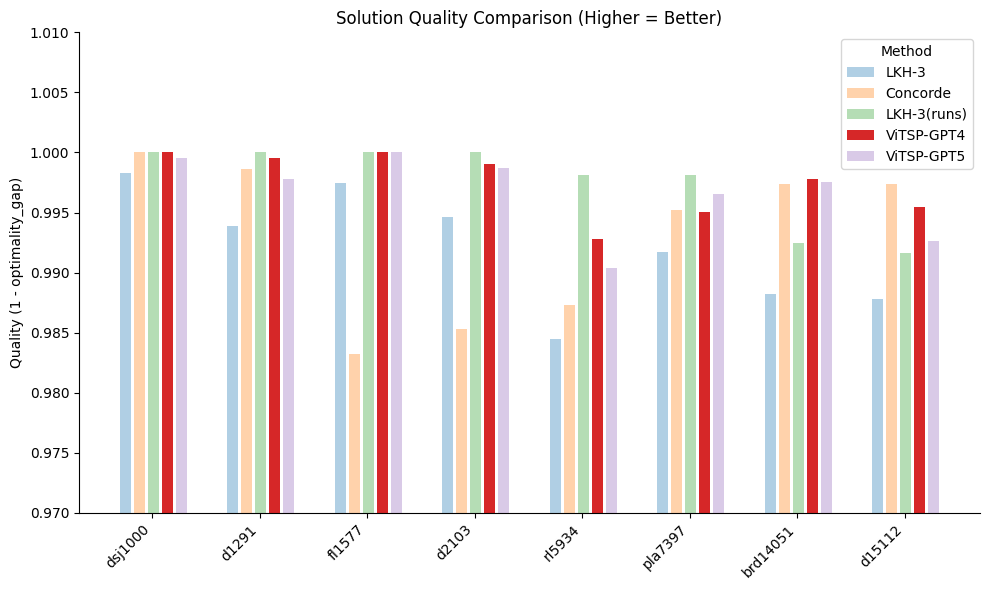

In [141]:
import matplotlib.pyplot as plt

# Step 1 — extract optimality gaps
df_gap = df_com.xs("optimality_gaps (%)", level=1)
# Step 2 — convert to (1 - gap)
df_quality = 1 - df_gap / 100.0

# Step 3 — plotting
plt.figure(figsize=(10, 6))

ax = plt.gca()
x = range(len(df_quality.columns))

# amount of spacing between each bar group
bar_width = 0.10       # width of each bar
group_gap = 0.15       # extra gap between different methods

methods = df_quality.index.tolist()
n_methods = len(methods)

# full opacity for GPT4 line
highlight_method = "ViTSP-GPT4"

# draw bars manually (for spacing + transparency)
for i, method in enumerate(methods):
    values = df_quality.loc[method].values

    # shift bars: default is (i * bar_width), we add a gap between methods
    x_positions = [xx + i * (bar_width + group_gap/n_methods) for xx in x]

    # transparency rule
    alpha = 1.0 if method == highlight_method else 0.35

    ax.bar(
        x_positions,
        values,
        width=bar_width,
        label=method,
        alpha=alpha
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# formatting
plt.ylabel("Quality (1 - optimality_gap)")
plt.ylim(0.97, 1.01)
plt.title("Solution Quality Comparison (Higher = Better)")

plt.xticks(
    [xx + (n_methods * bar_width)/2 for xx in x],
    df_quality.columns,
    rotation=45,
    ha="right"
)

plt.legend(title="Method")
plt.tight_layout()
plt.savefig("deliverables/bar_comparison.jpg")
plt.show()


## Statistics 
- to compare different VLMs, we need to use the total request number instead of total time

right now:
- gpt5-minimal: brd14051 is invalid

## Concorde

In [78]:
task2time = dataframe2.loc['time'].to_dict()

In [79]:
task2time

{'d1291': 221.35,
 'dsj1000': 115.03,
 'd15112': 1975.57,
 'd2103': 597.74,
 'fl1577': 72.73}

In [80]:
from exact_concorde.exact_concorde import *
import os
os.environ["QSOPT_DIR"] = os.path.abspath("../pyconcorde/data/")

def run_concorde(task, t):
    file_parser = FileParser()
    solution_plotter = SolutionPlot()

    fname = './instances/tsplib/{}.tsp'.format(task)
    print("running:", fname)
    
    instance_info = file_parser.parse_instance_from_file(fname)
    coordinates = instance_info['COORDINATES']
    nodes = {i: (x, y) for i, (x, y) in enumerate(coordinates)}
    tsp_instance = TravelingSalesmenProblem(node_coords_dict=nodes)

    t1 = time.time()
    concorde_model = Concorde(nodes=list(nodes.keys()), coordinates=coordinates)
    concorde_model.optimize(timelimit=t, verbose=False)

    current_route = concorde_model.get_tsp_route()
    current_obj = concorde_model.get_objective_value()
    t2 = time.time()

    return current_obj, t2 - t1

concorde_objs = []
concorde_ts = []
concorde_opt_gaps = []

for task, t in task2time.items():
    obj, concorde_time = run_concorde(task, t)
    opt = int(open('./instances/opt/{}.opt.tour.txt'.format(task)).readlines()[-1].strip())
    concorde_objs.append(obj)
    concorde_ts.append(concorde_time)
    concorde_opt_gaps.append((obj - opt) / opt)



[WARNING] CuPy not found. Falling back to NumPy.
running: ./instances/tsplib/d1291.tsp


100%|█████████▉| 1297/1298 [00:00<00:00, 1104795.35it/s]
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
Hit time limit in bfs branching


Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 1291
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 63271
   0 Steps   Best: 55017   0.00 seconds
   5 Steps   Best: 54943   0.00 seconds
   7 Steps   Best: 54922   0.00 seconds
  12 Steps   Best: 53659   0.00 seconds
  15 Steps   Best: 53636   0.00 seconds
  20 Steps   Best: 53403   0.01 seconds
  26 Steps   Best: 53380   0.01 seconds
  33 Steps   Best: 53378   0.01 seconds
  44 Steps   Best: 52069   0.01 seconds
  58 Steps   Best: 52056   0.01 seconds
  63 Steps   Best: 52051   0.01 seconds
  67 Steps   Best: 52002   0.01 seconds
  77 Steps   Best: 51986   0.01 seconds
  79 Steps   Best: 51971   0.01 seconds
  94 Steps   Best: 51934   0.01 seconds
 103 Steps   Best: 51923   0.01 seconds
 106 Steps   Best: 51891   0.01 seconds
 116 Steps   Best: 51848   0.01 seconds
 130 Steps   Best: 51639   0.01 seconds
 155 Steps   Best: 51636   0.02 se

100%|█████████▉| 1006/1007 [00:00<00:00, 1131225.15it/s]

Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 1000
Rounded Euclidean Norm (CC_EUCLIDEAN)



need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed


CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 21705718
   0 Steps   Best: 19479513   0.00 seconds
   2 Steps   Best: 19244847   0.00 seconds
   4 Steps   Best: 19229870   0.00 seconds
   6 Steps   Best: 18992545   0.01 seconds
   8 Steps   Best: 18989225   0.01 seconds
   9 Steps   Best: 18986030   0.01 seconds
  12 Steps   Best: 18980394   0.01 seconds
  13 Steps   Best: 18972955   0.01 seconds
  14 Steps   Best: 18965171   0.01 seconds
  15 Steps   Best: 18951516   0.01 seconds
  20 Steps   Best: 18943394   0.01 seconds
  30 Steps   Best: 18935909   0.02 seconds
  41 Steps   Best: 18933305   0.02 seconds
  48 Steps   Best: 18920338   0.02 seconds
  53 Steps   Best: 18919767   0.02 seconds
  55 Steps   Best: 18915117   0.02 seconds
  56 Steps   Best: 18908976   0.02 seconds
  59 Steps   Best: 18895029   0.02 seconds
  66 Steps   Best: 18881972   0.02 seconds
  67 Steps   Best: 18876110   0.03 seconds
  76 Steps   Best: 18874987   0.03 seconds


100%|█████████▉| 15118/15119 [00:00<00:00, 1038954.78it/s]
TT Warning: Blossom with even number of teeth
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need to link an lp solver to use this function
CClp_getweight failed
find_candidate_cliques failed
need

Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 15112
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 1798570
   0 Steps   Best: 1597302   0.05 seconds
   2 Steps   Best: 1596968   0.05 seconds
   4 Steps   Best: 1596904   0.05 seconds
   5 Steps   Best: 1596330   0.05 seconds
   6 Steps   Best: 1596251   0.05 seconds
   7 Steps   Best: 1596062   0.05 seconds
   8 Steps   Best: 1595908   0.05 seconds
  10 Steps   Best: 1595688   0.05 seconds
  12 Steps   Best: 1595659   0.05 seconds
  13 Steps   Best: 1595633   0.05 seconds
  17 Steps   Best: 1595624   0.05 seconds
  18 Steps   Best: 1595599   0.05 seconds
  19 Steps   Best: 1595580   0.05 seconds
  20 Steps   Best: 1595553   0.05 seconds
  21 Steps   Best: 1595526   0.06 seconds
  22 Steps   Best: 1595415   0.06 seconds
  24 Steps   Best: 1595393   0.06 seconds
  25 Steps   Best: 1595174   0.06 seconds
  26 Steps   Best: 1595000   0.06 s

100%|█████████▉| 2109/2110 [00:00<00:00, 1039946.76it/s]
No acceptable pivot found


Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 2103
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 92091
   0 Steps   Best: 82071   0.00 seconds
   3 Steps   Best: 82060   0.00 seconds
   8 Steps   Best: 82054   0.00 seconds
  11 Steps   Best: 82048   0.00 seconds
  15 Steps   Best: 82022   0.00 seconds
  17 Steps   Best: 82007   0.00 seconds
  21 Steps   Best: 81959   0.00 seconds
  30 Steps   Best: 81947   0.01 seconds
  33 Steps   Best: 81936   0.01 seconds
  35 Steps   Best: 81918   0.01 seconds
  36 Steps   Best: 81870   0.01 seconds
  39 Steps   Best: 81866   0.01 seconds
  42 Steps   Best: 81862   0.01 seconds
  43 Steps   Best: 81821   0.01 seconds
  50 Steps   Best: 81801   0.01 seconds
  60 Steps   Best: 81792   0.01 seconds
  63 Steps   Best: 81790   0.01 seconds
  66 Steps   Best: 81786   0.01 seconds
  91 Steps   Best: 81764   0.01 seconds
 104 Steps   Best: 81763   0.02 se

100%|█████████▉| 1583/1584 [00:00<00:00, 1117963.16it/s]


Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 1577
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 25214
   0 Steps   Best: 23792   0.00 seconds
   4 Steps   Best: 23784   0.00 seconds
  13 Steps   Best: 23782   0.01 seconds
  22 Steps   Best: 23777   0.01 seconds
  31 Steps   Best: 23754   0.01 seconds
  32 Steps   Best: 23753   0.01 seconds
  51 Steps   Best: 23749   0.02 seconds
  52 Steps   Best: 23738   0.02 seconds
  53 Steps   Best: 23733   0.02 seconds
  54 Steps   Best: 23110   0.02 seconds
  55 Steps   Best: 23052   0.02 seconds
  60 Steps   Best: 23051   0.02 seconds
  98 Steps   Best: 23047   0.03 seconds
 114 Steps   Best: 23045   0.03 seconds
 133 Steps   Best: 23042   0.04 seconds
 137 Steps   Best: 23040   0.04 seconds
 138 Steps   Best: 23036   0.04 seconds
 139 Steps   Best: 23033   0.04 seconds
 172 Steps   Best: 23025   0.05 seconds
 223 Steps   Best: 23024   0.06 se

In [81]:
dataframe4 = pd.DataFrame([concorde_ts, concorde_objs, concorde_opt_gaps], columns=tasks, index=['time', 'objective', 'optimality_gaps'])
dataframe4

,d1291,dsj1000,d15112,d2103,fl1577
time,251.765765,3.448656e+01,2.113479e+03,3.704892e+03,1.229237e+02
objective,50872.000000,1.865969e+07,1.577228e+06,1.000000e+30,1.000000e+30
optimality_gaps,0.001398,-2.679501e-05,2.634316e-03,1.243008e+25,4.494584e+25


In [83]:
task2time

{'d1291': 221.35,
 'dsj1000': 115.03,
 'd15112': 1975.57,
 'd2103': 597.74,
 'fl1577': 72.73}

In [84]:
task = 'fl1577'
obj, t = run_concorde(task, task2time[task])

running: ./instances/tsplib/fl1577.tsp


100%|█████████▉| 1583/1584 [00:00<00:00, 737977.46it/s]


Problem Name: Pseudo_TSP_Instance
Problem Type: TSP
Number of Nodes: 1577
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 25214
   0 Steps   Best: 23792   0.00 seconds
   4 Steps   Best: 23784   0.00 seconds
  13 Steps   Best: 23782   0.01 seconds
  22 Steps   Best: 23777   0.01 seconds
  31 Steps   Best: 23754   0.01 seconds
  32 Steps   Best: 23753   0.01 seconds
  51 Steps   Best: 23749   0.01 seconds
  52 Steps   Best: 23738   0.02 seconds
  53 Steps   Best: 23733   0.02 seconds
  54 Steps   Best: 23110   0.02 seconds
  55 Steps   Best: 23052   0.02 seconds
  60 Steps   Best: 23051   0.02 seconds
  98 Steps   Best: 23047   0.03 seconds
 114 Steps   Best: 23045   0.03 seconds
 133 Steps   Best: 23042   0.04 seconds
 137 Steps   Best: 23040   0.04 seconds
 138 Steps   Best: 23036   0.04 seconds
 139 Steps   Best: 23033   0.04 seconds
 172 Steps   Best: 23025   0.04 seconds
 223 Steps   Best: 23024   0.06 se

In [100]:
dataframe3

,d1291,dsj1000,d15112,d2103,fl1577
time,251.765765,3.448656e+01,2.113479e+03,3.704892e+03,1.229237e+02
objective,50872.000000,1.865969e+07,1.577228e+06,1.000000e+30,1.000000e+30
optimality_gaps,0.001398,-2.679501e-05,2.634316e-03,1.243008e+25,4.494584e+25


In [99]:
dataframe3.loc["time", 'fl1577']

np.float64(122.9236752986908)

In [86]:
t

115.03366017341614

In [ ]:
task = 'fl1577'
obj, t = run_concorde(task, task2time[task])

In [102]:
dataframe3.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & d1291 & dsj1000 & d15112 & d2103 & fl1577 \\\\\n\\midrule\ntime & 251.765765 & 34.486558 & 2113.478674 & 3704.892238 & 122.923675 \\\\\nobjective & 50872.000000 & 18659688.000000 & 1577228.000000 & 1000000000000000019884624838656.000000 & 1000000000000000019884624838656.000000 \\\\\noptimality_gaps & 0.001398 & -0.000027 & 0.002634 & 12430080795525171413778432.000000 & 44945840262483706264944640.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Compare VLMs

In [68]:
import pandas as pd
from pathlib import Path

def weighted_avg(fast_val, fast_cnt, reason_val, reason_cnt):
    total = fast_cnt + reason_cnt
    weighted = (fast_val * fast_cnt).fillna(0) + (reason_val * reason_cnt).fillna(0)
    return weighted.div(total).fillna(0)

records = pd.read_csv(Path("llm_records.csv"))

report = pd.DataFrame({
    "Task": records["task"],
    "Model": records["fast_model"] + " | " + records["reason_model"],
    "fast Response Time": records["fast_avg_latency"],
    "reason Response Time": records["reason_avg_latency"],
    "Hit Rate": records["overall_hit_rate"],
})

report["Avg Gap Improvement"] = weighted_avg(
    records["fast_avg_improvement_pct"],
    records["fast_responses"],
    records["reason_avg_improvement_pct"],
    records["reason_responses"],
)

report["Avg Search Area"] = weighted_avg(
    records["fast_avg_search_area"],
    records["fast_responses"],
    records["reason_avg_search_area"],
    records["reason_responses"],
)

report["Efficiency"] = report['Hit Rate'] * report['Avg Gap Improvement'] * 100

report

,Task,Model,fast Response Time,reason Response Time,Hit Rate,Avg Gap Improvement,Avg Search Area,Efficiency
0,dsj1000,GPT4-fast | GPT4-reason,3.069743,7.546245,0.428571,0.030128,0.180807,1.291192
1,d1291,GPT4-fast | GPT4-reason,2.887460,18.991008,0.189189,0.084538,0.273293,1.599360
2,fl1577,GPT4-fast | GPT4-reason,2.961921,12.546278,0.285714,0.082187,0.149451,2.348191
3,d2103,GPT4-fast | GPT4-reason,2.634167,15.409245,0.102041,0.043981,0.292279,0.448788
4,rl5934,GPT4-fast | GPT4-reason,2.705013,12.741500,0.115566,0.021797,0.157895,0.251905
5,pla7397,GPT4-fast | GPT4-reason,8.631371,16.670067,0.110769,0.015804,0.256883,0.175057
6,brd14051,GPT4-fast | GPT4-reason,7.875830,16.593003,0.206667,0.018665,0.166479,0.385750
7,d15112,GPT4-fast | GPT4-reason,2.671239,10.117686,0.166307,0.009763,0.104581,0.162367
8,dsj1000,GPT5-fast | GPT5-reason,3.072159,3.260610,0.333333,0.023433,0.144190,0.781091
9,d1291,GPT5-fast | GPT5-reason,2.190239,3.359725,0.238095,0.084425,0.338383,2.010126


In [47]:
report.to_csv()

',Task,Model,fast Response Time,reason Response Time,Hit Rate,Avg Gap Improvement,Avg Search Area\n0,dsj1000,GPT4-fast | GPT4-reason,3.0697430610656737,7.546245098114014,0.4285714285714285,0.030127803438554642,0.18080718330616988\n1,d1291,GPT4-fast | GPT4-reason,2.8874602828707014,18.99100767241584,0.1891891891891892,0.08453759954714654,0.2732933836585833\n2,fl1577,GPT4-fast | GPT4-reason,2.9619210720062257,12.546278059482574,0.2857142857142857,0.08218667933711303,0.1494510932626263\n3,d2103,GPT4-fast | GPT4-reason,2.634167382591649,15.40924533930692,0.1020408163265306,0.04398122562529405,0.29227856364327903\n4,rl5934,GPT4-fast | GPT4-reason,2.705013317583448,12.741499865573385,0.115566037735849,0.021797473312803847,0.15789480850593005\n5,pla7397,GPT4-fast | GPT4-reason,8.631370649193272,16.670066619482565,0.1107692307692307,0.01580375961776229,0.2568826492775923\n6,brd14051,GPT4-fast | GPT4-reason,7.875830113218072,16.593003372677035,0.2066666666666666,0.018665342830393835,0.166479332

In [69]:
styled = (
      report
      .sort_values(["Task", "Model"])
      .set_index(["Task", "Model"])
      .style.format({
          "fast Response Time": "{:.2f}s",
          "reason Response Time": "{:.2f}s",
          "Hit Rate": "{:.2%}",
          "Avg Gap Improvement": "{:.2}%",
          "Avg Search Area": "{:.3f}"
      })
  )

In [70]:
styled

In [93]:
from pathlib import Path

# derive per-task node counts so plots can be ordered by problem size

def read_dimension(task_name: str) -> int:
    task_file = Path('instances/tsplib') / f"{task_name}.tsp"
    with open(task_file, 'r', encoding='utf-8') as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if line.startswith('DIMENSION'):
                tokens = line.replace(':', ' ').split()
                return int(tokens[-1])
    raise ValueError(f'Could not find DIMENSION for {task_name}')


task_node_counts = {task: read_dimension(task) for task in report['Task'].unique()}
ordered_tasks = sorted(task_node_counts, key=lambda task: task_node_counts[task])
report_with_meta = report.copy()
report_with_meta['Num Nodes'] = report_with_meta['Task'].map(task_node_counts)
report_with_meta = report_with_meta.sort_values(['Num Nodes', 'Model'])
task_labels = [f"{task}" for task in ordered_tasks]


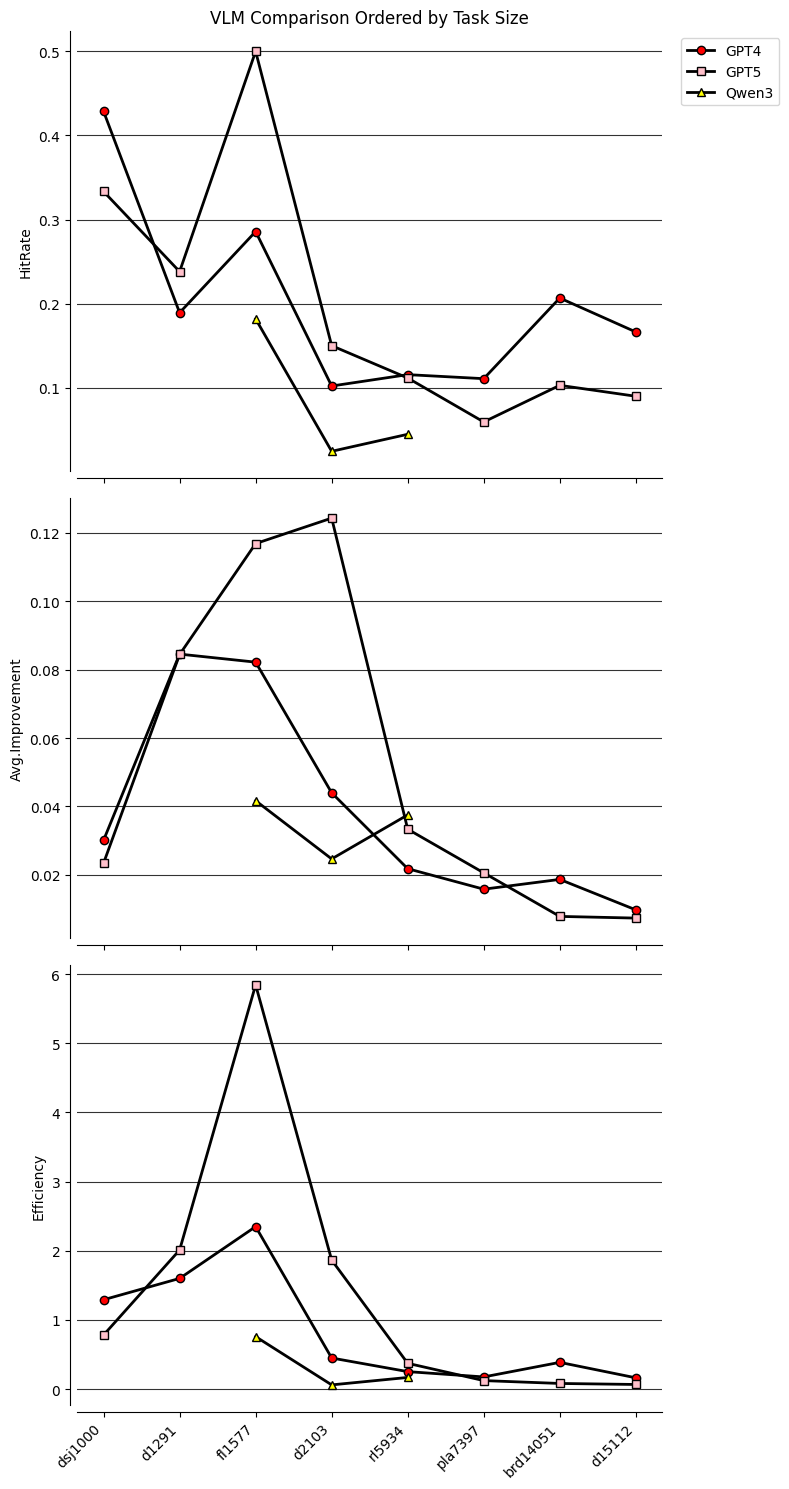

In [119]:
import matplotlib.pyplot as plt

metrics = ['Hit Rate', 'Avg Gap Improvement', 'Efficiency']
metric_names = ['HitRate', 'Avg.Improvement', 'Efficiency']
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 15), sharex=True)
x_positions = list(range(len(ordered_tasks)))

colors = ['red', 'pink', 'yellow', 'green']
markers = ['o', 's', '^', '*']
model_names = ["GPT4", "GPT5", "Qwen3", "Qwen3-SFT"]
for idx, metric in enumerate(metrics):
    pivot = (
        report_with_meta
        .pivot_table(index='Task', columns='Model', values=metric, aggfunc='mean')
        .reindex(ordered_tasks)
    )

    for j, model in enumerate(pivot.columns):
        if j >=3: continue
        axes.plot(
            x_positions,
            pivot[model].values,
            # marker='o',
            linewidth=2,
            label=model_names[j],
            # color=colors[j],
            color='black',
            marker=markers[j],
            markerfacecolor=colors[j]
        )
        axes.spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        axes[idx].spines['left'].set_position(('outward', 5))
        axes[idx].spines['bottom'].set_position(('outward', 5))
        # axes[idx].yaxis.set_ticks_position('left')
        # axes[idx].xaxis.set_ticks_position('bottom')

    axes[idx].set_ylabel(metric_names[idx])
    axes[idx].grid(alpha=0.8, linestyle='-', axis="y", color='black')

axes[-1].set_xticks(x_positions)
axes[-1].set_xticklabels(task_labels, rotation=45, ha='right')
axes[0].set_title('VLM Comparison Ordered by Task Size')
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig('deliverables/vlm_metric_lineplots.jpg', dpi=300)
plt.show()


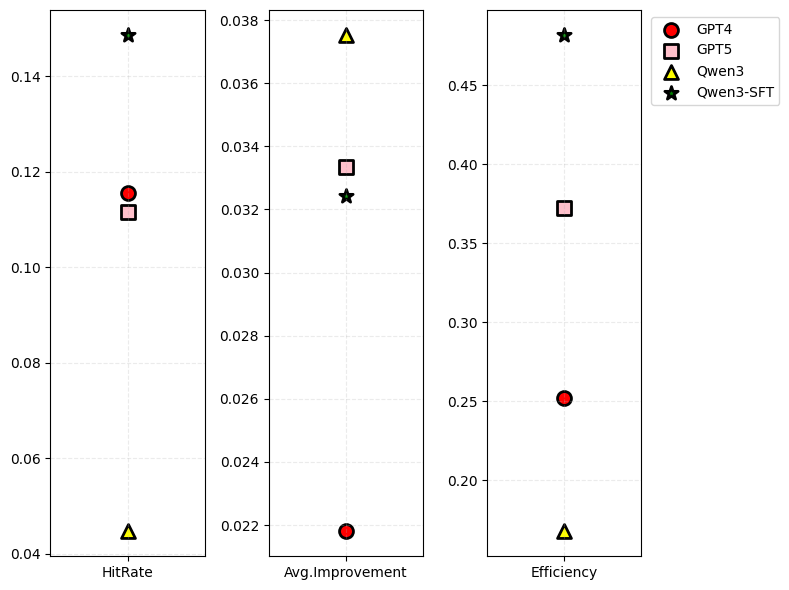

In [120]:
import matplotlib.pyplot as plt

metrics = ['Hit Rate', 'Avg Gap Improvement', 'Efficiency']
metric_names = ['HitRate', 'Avg.Improvement', 'Efficiency']
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 6))
ordered_tasks_1 = ['rl5934']
x_positions = list(range(len(ordered_tasks_1)))

colors = ['red', 'pink', 'yellow', 'green']
model_names = ["GPT4", "GPT5", "Qwen3", "Qwen3-SFT"]
for idx, metric in enumerate(metrics):
    pivot = (
        report_with_meta
        .pivot_table(index='Task', columns='Model', values=metric, aggfunc='mean')
        .reindex(ordered_tasks_1)
    )

    for j, model in enumerate(pivot.columns):
        # axes[idx].hlines(pivot[model].values, -0.05, 0.05, colors='black')
        axes[idx].scatter(
            x_positions,
            pivot[model].values,
            marker=markers[j],
            linewidth=2,
            label=model_names[j],
            color=colors[j],
            edgecolors="black",
            s=100
        )

    # axes[idx].set_ylabel(metric)
    axes[idx].grid(alpha=0.25, linestyle='--')
    axes[idx].set_xticks(x_positions)
    # axes[idx].set_xticklabels(ordered_tasks_1)
    axes[idx].set_xticklabels([metric_names[idx]])
    axes[idx].set_xlim(-0.2, 0.2)


axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig('deliverables/vlm_metric_scatters_rl.jpg', dpi=300)
plt.show()


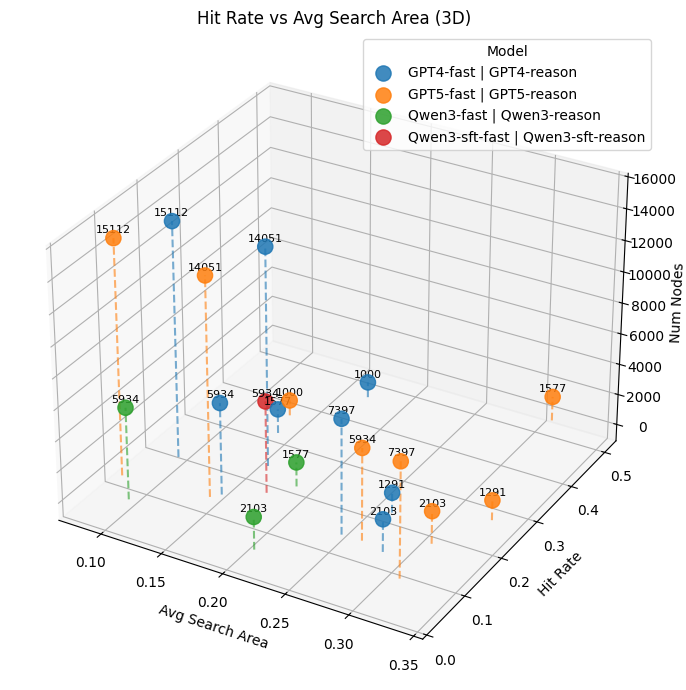

In [46]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from itertools import cycle

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for model, group in report_with_meta.groupby('Model'):
    color = next(color_cycle)
    ax.scatter(
        group['Avg Search Area'],
        group['Hit Rate'],
        group['Num Nodes'],
        s=120,
        alpha=0.85,
        color=color,
        label=model
    )
    for _, row in group.iterrows():
        node_count = int(row['Num Nodes'])
        label = f"{node_count}"
        x_val = row['Avg Search Area']
        y_val = row['Hit Rate']
        ax.text(
            x_val,
            y_val,
            node_count+300,
            label,
            zdir=None,
            ha='center',
            fontsize=8
        )
        ax.plot(
            [x_val, x_val],
            [y_val, y_val],
            [0, node_count],
            linestyle='--',
            color=color,
            alpha=0.6
        )

ax.set_xlabel('Avg Search Area')
ax.set_ylabel('Hit Rate')
ax.set_zlabel('Num Nodes')
ax.set_title('Hit Rate vs Avg Search Area (3D)')
ax.grid(alpha=0.25, linestyle='--')
ax.legend(title='Model')
plt.tight_layout()
plt.savefig('deliverables/vlm_searcharea_hitrate.jpg', dpi=300)
plt.show()
